In [1]:
import numpy as np
import io, gzip, requests
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping


from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD

import cv2, gc
import h5py as h5py 
import numpy as np
np.random.seed(962342)

Using CNTK backend
c:\Anaconda3\envs\cntkkeraspy35\lib\site-packages\keras-2.0.4-py3.5.egg\keras\backend\cntk_backend.py:19: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


In [7]:
train_image_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
train_label_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
test_image_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
test_label_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"

In [8]:
def readRemoteGZipFile(url, isLabel=True):
    response=requests.get(url, stream=True)
    gzip_content = response.content
    fObj = io.BytesIO(gzip_content)
    content = gzip.GzipFile(fileobj=fObj).read()
    if isLabel:
        offset=8
    else:
        offset=16
    result = np.frombuffer(content, dtype=np.uint8, offset=offset)    
    return(result)

In [9]:
train_labels = readRemoteGZipFile(train_label_url, isLabel=True)
train_images_raw = readRemoteGZipFile(train_image_url, isLabel=False)

test_labels = readRemoteGZipFile(test_label_url, isLabel=True)
test_images_raw = readRemoteGZipFile(test_image_url, isLabel=False)

In [16]:
train_images = train_images_raw.reshape(len(train_labels), 784)
test_images = test_images_raw.reshape(len(test_labels), 784)

In [10]:
print(len(train_labels))
print(len(train_images_raw))
print(len(train_images_raw)/len(train_labels))

60000
47040000
784.0


# Transfer Learning

In [11]:
from keras.applications import VGG16

In [12]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import SGD

In [13]:
import cv2
import h5py as h5py

In [18]:
def tran_y(y): 
    y_ohe = np.zeros(10) 
    y_ohe[y] = 1 
    return y_ohe

In [14]:
ishape=64

In [19]:
X_train = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in train_images] 
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32') 
X_train /= 255.0

X_test = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in test_images] 
X_test = np.concatenate([arr[np.newaxis] for arr in X_test]).astype('float32')
X_test /= 255.0

y_train_ohe = np.array([tran_y(train_labels[i]) for i in range(len(train_labels))]) 
y_test_ohe = np.array([tran_y(test_labels[i]) for i in range(len(test_labels))])
y_train_ohe = y_train_ohe.astype('float32')
y_test_ohe = y_test_ohe.astype('float32')

In [20]:
model_vgg = VGG16(include_top = False, weights = 'imagenet', input_shape =(ishape,ishape,3))

for layer in model_vgg.layers:
    layer.trainable = False

model = Flatten(name = 'flatten')(model_vgg.output)
model = Dense(4096, activation='relu', name='fc1')(model)
model = Dense(4096, activation='relu', name='fc2')(model)
model = Dropout(0.5)(model)
model = Dense(10, activation = 'softmax')(model)
model_vgg_mnist = Model(model_vgg.input, model, name = 'vgg16')
model_vgg_mnist.summary()
model_vgg_mnist.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [22]:
sgd = SGD(lr = 0.05, decay = 1e-5) 
model_vgg_mnist.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [23]:
model_vgg_mnist.fit(X_train, y_train_ohe, validation_data = (X_test, y_test_ohe), epochs = 10, batch_size = 64)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 89s - loss: 1.1489 - acc: 0.5591 - val_loss: 0.9437 - val_acc: 0.6399
Epoch 2/10
60000/60000 [==============================] - 83s - loss: 0.8973 - acc: 0.6531 - val_loss: 0.8798 - val_acc: 0.6706
Epoch 3/10
60000/60000 [==============================] - 84s - loss: 0.8305 - acc: 0.6829 - val_loss: 0.8411 - val_acc: 0.6698
Epoch 4/10
60000/60000 [==============================] - 84s - loss: 0.7951 - acc: 0.6940 - val_loss: 0.8688 - val_acc: 0.6774
Epoch 5/10
60000/60000 [==============================] - 84s - loss: 0.7687 - acc: 0.7068 - val_loss: 1.0032 - val_acc: 0.6194
Epoch 6/10
60000/60000 [==============================] - 84s - loss: 0.7451 - acc: 0.7164 - val_loss: 0.7500 - val_acc: 0.7154
Epoch 7/10
60000/60000 [==============================] - 84s - loss: 0.7276 - acc: 0.7217 - val_loss: 0.7495 - val_acc: 0.7086
Epoch 8/10
60000/60000 [==============================

In [ ]:
model_vgg = VGG16(include_top = False, weights = 'imagenet', input_shape =(ishape,ishape,3))
model = Flatten(name = 'flatten')(model_vgg.output)
model = Dense(10, activation = 'softmax')(model)
model_vgg_mnist = Model(model_vgg.input, model, name = 'vgg16')
model_vgg_mnist.summary()
model_vgg_mnist.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1)(user_in)

movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
v = Embedding(n_movies, n_factors, input_length=1)(movie_in)

x = merge([u, v], mode='dot')
x = Flatten()(x)

model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [12]:
X_train = train_images
X_test = test_images
Y_train = train_labels
Y_test = test_labels

In [13]:
X_train.shape

(60000, 784)

In [14]:
X_train = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32')
X_test = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in X_test]
X_test = np.concatenate([arr[np.newaxis] for arr in X_test]).astype('float32')

In [15]:
X_train /= 255
X_test /= 255

Y_train2 = keras.utils.to_categorical(Y_train).astype('float32')
Y_test2 = keras.utils.to_categorical(Y_test).astype('float32')

In [16]:
#model_vgg_mnist.fit(X_train, Y_train2, validation_data = (X_test, Y_test2), epochs = 25, batch_size = 100)

# Some CNN

In [17]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation

In [18]:
X_train = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
X_test = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

X_train /= 255
X_test /= 255

Y_train = train_labels
Y_test = test_labels
Y_train2 = keras.utils.to_categorical(Y_train).astype('float32')
Y_test2 = keras.utils.to_categorical(Y_test).astype('float32')

Visualize data with tSNE

In [19]:
from sklearn import manifold
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
plt.rcParams['figure.figsize']=(20, 10)
# Scale and visualize the embedding vectors
def plot_embedding(X, Image, Y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(Y[i]),
                 color=plt.cm.Set1(Y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(Image[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [20]:
samples=np.random.choice(range(len(Y_train)), size=1000)

In [21]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
sample_images = train_images[samples]
sample_targets = train_labels[samples]
X_tsne = tsne.fit_transform(sample_images)
t1 = time()

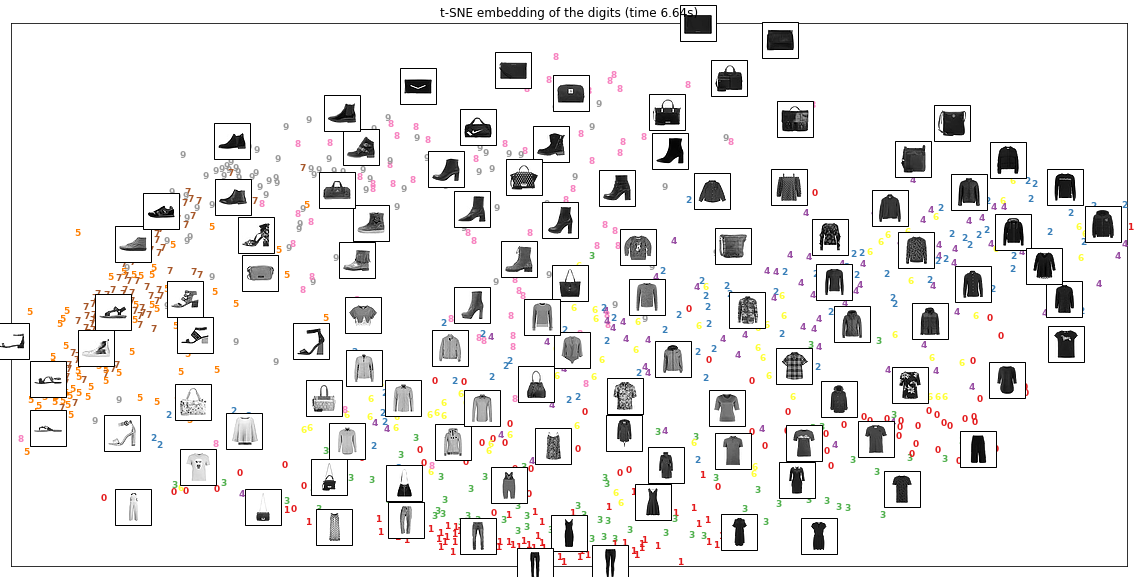

In [22]:
plot_embedding(X_tsne, sample_images.reshape(sample_targets.shape[0], 28, 28), sample_targets,
               "t-SNE embedding of the digits (time %.2fs)" %
               (t1 - t0))
plt.show()

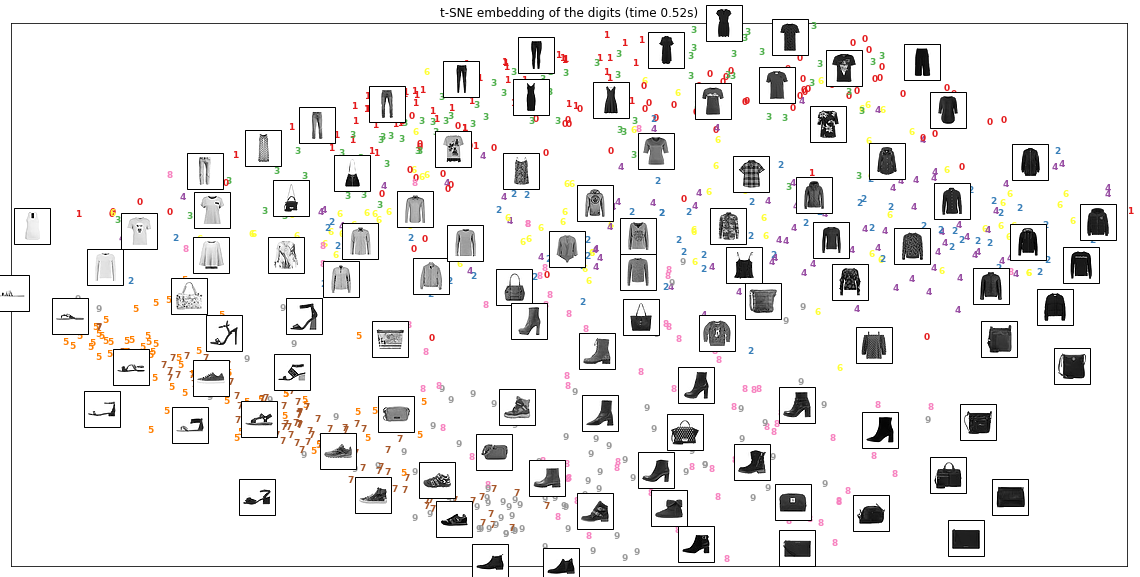

In [23]:
t0=time()
X_svd, s, v = np.linalg.svd(sample_images, full_matrices=False)
t1=time()
plot_embedding(X_svd[:, :2], sample_images.reshape(sample_targets.shape[0], 28, 28), sample_targets,
               "t-SNE embedding of the digits (time %.2fs)" %
               (t1 - t0))
plt.show()

In [52]:
num_classes = len(set(Y_train))
model2=Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", 
          input_shape=X_train.shape[1:], activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(Conv2D(filters=256, kernel_size=(3, 3), padding="valid", activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256))
model2.add(Activation('relu'))
#model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 256)         0         
__________

In [25]:
model2_fit=model2.fit(X_train, Y_train2, validation_data = (X_test, Y_test2), epochs=50, verbose=1, batch_size=500)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 23s - loss: 0.7681 - acc: 0.7195 - val_loss: 0.4257 - val_acc: 0.8383
Epoch 2/50
60000/60000 [==============================] - 21s - loss: 0.4223 - acc: 0.8461 - val_loss: 0.3452 - val_acc: 0.8706
Epoch 3/50
60000/60000 [==============================] - 21s - loss: 0.3573 - acc: 0.8676 - val_loss: 0.2976 - val_acc: 0.8916
Epoch 4/50
60000/60000 [==============================] - 21s - loss: 0.3179 - acc: 0.8843 - val_loss: 0.2720 - val_acc: 0.9026
Epoch 5/50
60000/60000 [==============================] - 21s - loss: 0.2930 - acc: 0.8933 - val_loss: 0.2593 - val_acc: 0.9034
Epoch 6/50
60000/60000 [==============================] - 21s - loss: 0.2714 - acc: 0.8997 - val_loss: 0.2420 - val_acc: 0.9100
Epoch 7/50
60000/60000 [==============================] - 21s - loss: 0.2600 - acc: 0.9043 - val_loss: 0.2305 - val_acc: 0.9155
Epoch 8/50
60000/60000 [==============================

In [26]:
train_accuracy = model2_fit.history['acc']
test_accuracy = model2_fit.history['val_acc']

plt.plot(train_accuracy, label='Train Accuracy ', c='g', linewidth=3)
plt.plot(test_accuracy, label='Test Accuracy ', color='r', linewidth=3)
plt.axhline(y=0.945, linestyle='--', c='b')
plt.ylim(0.90, 1)
plt.legend()
plt.show()

In [32]:
num_classes = len(set(Y_train))
model3=Sequential()

model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu',
          input_shape=X_train.shape[1:], name='Conv2D1'))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', name='Conv2D2'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='MaxPool2D1'))
model3.add(Dropout(0.5, name='Dropout1'))

model3.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', name='Conv2D3'))
model3.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu', name='Conv2D4'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='MaxPool2D2'))
model3.add(Dropout(0.5, name='Dropout2'))


model3.add(Flatten(name='Flatten'))
model3.add(Dense(256, name='Dense1'))
model3.add(LeakyReLU(name='LeakyRelu1'))
model3.add(Dropout(0.5, name='Dropout4'))
model3.add(Dense(256, name='Dense2'))
model3.add(LeakyReLU(name='LeakyRelu2'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes, activation='softmax', name='output'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D1 (Conv2D)             (None, 28, 28, 32)        320       
_________________________________________________________________
Conv2D2 (Conv2D)             (None, 28, 28, 64)        18496     
_________________________________________________________________
MaxPool2D1 (MaxPooling2D)    (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2D3 (Conv2D)             (None, 14, 14, 128)       73856     
_________________________________________________________________
Conv2D4 (Conv2D)             (None, 14, 14, 256)       295168    
_________________________________________________________________
MaxPool2D2 (MaxPooling2D)    (None, 7, 7, 256)         0         
__________

In [33]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=0),    
]
model3_fit=model3.fit(X_train, Y_train2, validation_data = (X_test, Y_test2), epochs=50, verbose=1, batch_size=1000, callbacks=callbacks)
score = model3.evaluate(X_test, Y_test2)
print(score)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 28s - loss: 0.8362 - acc: 0.6880 - val_loss: 0.4638 - val_acc: 0.8321
Epoch 2/50
60000/60000 [==============================] - 25s - loss: 0.4331 - acc: 0.8411 - val_loss: 0.3683 - val_acc: 0.8686
Epoch 3/50
60000/60000 [==============================] - 26s - loss: 0.3551 - acc: 0.8685 - val_loss: 0.3202 - val_acc: 0.8777
Epoch 4/50
60000/60000 [==============================] - 26s - loss: 0.3103 - acc: 0.8884 - val_loss: 0.2809 - val_acc: 0.8953
Epoch 5/50
60000/60000 [==============================] - 25s - loss: 0.2804 - acc: 0.8962 - val_loss: 0.2551 - val_acc: 0.9059
Epoch 6/50
60000/60000 [==============================] - 26s - loss: 0.2602 - acc: 0.9040 - val_loss: 0.2468 - val_acc: 0.9108
Epoch 7/50
60000/60000 [==============================] - 25s - loss: 0.2439 - acc: 0.9109 - val_loss: 0.2309 - val_acc: 0.9165
Epoch 8/50
60000/60000 [==============================

In [38]:
model3.evaluate(X_test, Y_test2)

 9824/10000 [============================>.] - ETA: 0s

[0.18665539267361164, 0.93930000000000002]

In [31]:
import gc
try:
    del model3_fit
    del model3
except:
    print('Object Gone')

for i in range(50):
    gc.collect()

Object Gone


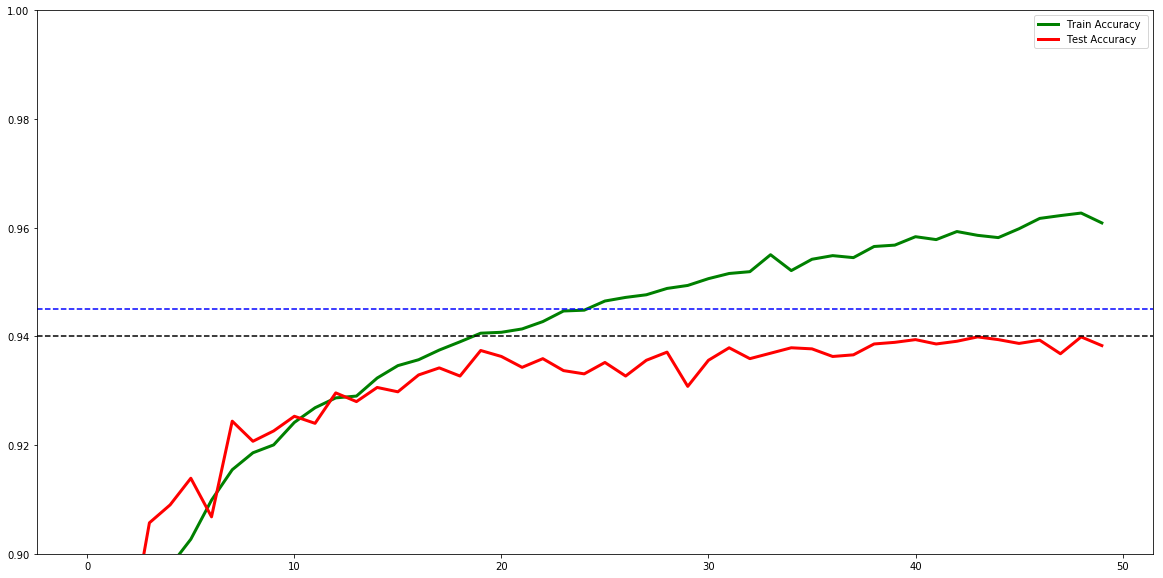

In [50]:
train_accuracy = model3_fit.history['acc']
test_accuracy = model3_fit.history['val_acc']

plt.plot(train_accuracy, label='Train Accuracy ', c='g', linewidth=3)
plt.plot(test_accuracy, label='Test Accuracy ', color='r', linewidth=3)
plt.axhline(y=0.945, linestyle='--', c='b')
plt.axhline(y=0.940, linestyle="--", c='black')
plt.ylim(0.90, 1)
plt.legend()
plt.show()

# Try automatic augumentation with horizontal Flipping and shifting

In [24]:
from keras.preprocessing.image import ImageDataGenerator

In [52]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=0, # Degree range for random rotations.    
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
batchSize = 256
epochs=50
steps = len(X_train) // batchSize
model3_fitGen= model3.fit_generator(datagen.flow(X_train, Y_train2, batch_size=batchSize), steps_per_epoch=steps, epochs=epochs)

Epoch 1/50


c:\Anaconda3\envs\cntkkeraspy35\lib\site-packages\keras-2.0.4-py3.5.egg\keras\preprocessing\image.py:503: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


234/234 [==============================] - 39s - loss: 0.5625 - acc: 0.8004    
Epoch 2/50
234/234 [==============================] - 38s - loss: 0.4086 - acc: 0.8503    
Epoch 3/50
234/234 [==============================] - 38s - loss: 0.3821 - acc: 0.8610    
Epoch 4/50
234/234 [==============================] - 38s - loss: 0.3664 - acc: 0.8666    
Epoch 5/50
234/234 [==============================] - 37s - loss: 0.3550 - acc: 0.8715    
Epoch 6/50
234/234 [==============================] - 38s - loss: 0.3420 - acc: 0.8756    
Epoch 7/50
234/234 [==============================] - 38s - loss: 0.3364 - acc: 0.8769    
Epoch 8/50
234/234 [==============================] - 37s - loss: 0.3299 - acc: 0.8793    
Epoch 9/50
234/234 [==============================] - 38s - loss: 0.3197 - acc: 0.8833    
Epoch 10/50
234/234 [==============================] - 37s - loss: 0.3218 - acc: 0.8827    
Epoch 11/50
234/234 [==============================] - 38s - loss: 0.3127 - acc: 0.8855    
Epoch 12

借助ImageDataGenerator的源代码，我们也可以自己构造定制的图像变换函数。这样可以将数据预先整理好，一次性输入模型进行拟合，因为减少了数据在内存和显卡之间的转移，会比使用ImageDataGenerator这种data generator逐次给模型喂数据快很多。

In [25]:
from keras.preprocessing.image import random_rotation, flip_axis

In [47]:
X_train[1].shape

(28, 28, 1)

In [53]:
%%time

Nsample=20000
samplelist = np.random.choice(range(len(X_train)), Nsample)
z= X_train[samplelist].copy()
for i in range(Nsample):
    z[i] = flip_axis(X_train[i], 1)   
    
X_train2 = np.vstack((X_train, z))
Y_train3 = np.vstack((Y_train2, Y_train2[samplelist]))

samplelist = np.random.choice(range(len(X_train)), Nsample)
z= X_train[samplelist].copy()
for i in range(Nsample):
    z[i] = flip_axis(X_train[i], 2)   
    
X_train2 = np.vstack((X_train2, z))
Y_train3 = np.vstack((Y_train3, Y_train2[samplelist]))

Wall time: 651 ms


In [54]:
X_train2 -= 0.5
X_train2 *= 2.0

X_test -= 0.5
X_test *= 2.0

In [56]:
model2_fit3=model3.fit(X_train2, Y_train3, validation_data = (X_test, Y_test2), epochs=30, verbose=1, batch_size=256)

Train on 100000 samples, validate on 10000 samples
Epoch 1/30
100000/100000 [==============================] - 37s - loss: 2.3398 - acc: 0.3980 - val_loss: 0.8912 - val_acc: 0.7928
Epoch 2/30
100000/100000 [==============================] - 37s - loss: 1.7080 - acc: 0.5069 - val_loss: 0.6932 - val_acc: 0.8494
Epoch 3/30
100000/100000 [==============================] - 37s - loss: 1.6506 - acc: 0.5317 - val_loss: 0.6171 - val_acc: 0.8703
Epoch 4/30
100000/100000 [==============================] - 37s - loss: 1.6111 - acc: 0.5477 - val_loss: 0.6224 - val_acc: 0.8838
Epoch 5/30
100000/100000 [==============================] - 38s - loss: 1.5857 - acc: 0.5556 - val_loss: 0.6587 - val_acc: 0.8794
Epoch 6/30
100000/100000 [==============================] - 37s - loss: 1.5665 - acc: 0.5626 - val_loss: 0.5461 - val_acc: 0.8958
Epoch 7/30
100000/100000 [==============================] - 37s - loss: 1.5580 - acc: 0.5670 - val_loss: 0.5412 - val_acc: 0.8971
Epoch 8/30
100000/100000 [=============

效果似乎一般

# Fully Connected MLP

In [74]:
mlp = Sequential()
mlp.add(Dense(256, input_shape=(784,)))
mlp.add(Activation('tanh'))
mlp.add(Dropout(0.4))
mlp.add(Dense(512))
mlp.add(Activation('tanh'))
mlp.add(Dropout(0.4))
mlp.add(Dense(100))
mlp.add(Activation('relu'))  
mlp.add(Dropout(0.5))
mlp.add(Dense(10, activation='softmax'))
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               131584    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 100)               51300     
__________

In [58]:
train_images2 = train_images.reshape(-1, 784) / 255
train_images2 = train_images2.astype('float32')
test_images2 = test_images.reshape(-1, 784) / 255
test_images2 = test_images2.astype('float32')

In [75]:
mlp.fit(train_images2, Y_train2, validation_data = (test_images2, Y_test2), epochs=50, verbose=1, batch_size=300)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s - loss: 0.7683 - acc: 0.7240 - val_loss: 0.4781 - val_acc: 0.8218
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 0.5250 - acc: 0.8125 - val_loss: 0.4397 - val_acc: 0.8356
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 0.4847 - acc: 0.8274 - val_loss: 0.4289 - val_acc: 0.8422
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 0.4634 - acc: 0.8356 - val_loss: 0.4277 - val_acc: 0.8390
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 0.4445 - acc: 0.8409 - val_loss: 0.4038 - val_acc: 0.8498
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 0.4331 - acc: 0.8441 - val_loss: 0.3987 - val_acc: 0.8564
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 0.4194 - acc: 0.8494 - val_loss: 0.3973 - val_acc: 0.8534
Epoch 8/50
60000/60000 [==============================] - 2s 

In [31]:
'''
回收内存
'''
import gc
try:
    del model3, model3_fit
except:
    print('目标变量消失')
for i in range(10):
    gc.collect()

目标变量消失
